# 1. Load libraries and create some functions

In [1]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import keras
from keras.utils import image_dataset_from_directory
from keras.optimizers import Adam
from keras import Sequential, Model
from keras.layers import (
    GlobalAveragePooling2D, Flatten, Input,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization,
    MaxPooling2D, UpSampling2D, Rescaling, Resizing)
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from IPython.display import clear_output

from datetime import datetime
import time

from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.applications.vgg16 import preprocess_input

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import random
random_seed = 5
np.random.seed(random_seed)
random.seed(random_seed)
tf.random.set_seed(random_seed)

In [3]:
class PlotLearning(Callback):
    """
    Callback to plot metrics during training
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')
        
        f, axs = plt.subplots(1,len(metric),figsize=(10,4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

In [4]:
def get_model_metrics(test_data, model, model_name):
    """
    Evaluates a binary classification model on test data and reports various performance metrics.
    It calculates the confusion matrix, ROC curve, and several statistical measures including accuracy, 
    sensitivity, specificity, precision, NPV (Negative Predictive Value), PLR (Positive Likelihood Ratio), 
    NLR (Negative Likelihood Ratio), and F1-score. Additionally, it identifies the best threshold for 
    classification based on F1-score optimization.

    The function saves the confusion matrix and ROC curve plots in a local directory, and appends the 
    calculated metrics to a CSV file. This file is created if it doesn't exist, or updated if it does.

    Parameters:
    - test_data (iterable): The test dataset, typically a generator or an iterable that yields batches 
      of images and labels.
    - model (keras.Model): The trained Keras model to evaluate.
    - model_name (str): The name of the model, used for saving output files.

    No return value. The function directly prints the calculated metrics and saves the results and plots 
    to the local file system.
    """
    timestamp = datetime.now().strftime("%Y%m%d%H%M%S")
    results_folder = 'results'
    csv_file = f'{results_folder}/model_performance.csv'
    
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    predicted_probs = []
    true_labels = []

    for images, labels in test_data:
        predictions = model.predict(images, verbose=0)
        predicted_probs.extend(predictions.flatten())
        true_labels.extend([int(label) for label in labels])

    # determine the best threshold
    thresholds = np.linspace(0, 1, 100)
    best_f1 = 0
    best_threshold = 0.5
    for thresh in thresholds:
        predicted_labels = [1 if p > thresh else 0 for p in predicted_probs]
        f1 = f1_score(true_labels, predicted_labels)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = thresh

    print(f"Best threshold: {best_threshold:.2f} with F1-score: {best_f1:.2f}")
    
    # recalculate predictions with the best threshold
    final_predicted_labels = [1 if p > best_threshold else 0 for p in predicted_probs]
    
    # Confusion Matrix
    confusion_mtx = confusion_matrix(true_labels, final_predicted_labels)
    # plot the confusion matrix
    f,ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Purples",linecolor="gray", fmt= '.1f',ax=ax)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_confusion_matrix.png')
    plt.show()
    
    # Classification report
    report = classification_report(true_labels, final_predicted_labels)
    print(report)

    # calculate additional metrics
    TP = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 1))
    TN = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 0))
    FP = sum((np.array(true_labels) == 0) & (np.array(final_predicted_labels) == 1))
    FN = sum((np.array(true_labels) == 1) & (np.array(final_predicted_labels) == 0))

    accuracy = accuracy_score(true_labels, final_predicted_labels)
    sensitivity = recall_score(true_labels, final_predicted_labels)  # recall
    specificity = TN / (TN + FP)
    precision = precision_score(true_labels, final_predicted_labels)  # PPV
    npv = TN / (TN + FN)
    plr = sensitivity / (1 - specificity)
    nlr = (1 - sensitivity) / specificity
    f1_pos_class = f1_score(true_labels, final_predicted_labels)

    # ROC AUC
    fpr, tpr, _ = roc_curve(true_labels, predicted_probs)
    roc_auc = auc(fpr, tpr)

    # create a DataFrame and append to the CSV file
    df = pd.DataFrame({
        'Model Name': [model_name],
        'AUC': [roc_auc],
        'F1-Score Positive Class': [f1_pos_class],
        'Accuracy': [accuracy],
        'Sensitivity': [sensitivity],
        'Specificity': [specificity],
        'PPV': [precision],
        'NPV': [npv],
        'PLR': [plr],
        'NLR': [nlr]
    }).round(2) 

    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)

    print(df)

    # plotting and saving ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.savefig(f'{results_folder}/{model_name}_run_{timestamp}_roc_curve.png')
    plt.show()

In [5]:
def build_model(base_model, transfer_learning):
    """
    Constructs and returns a neural network model tailored for binary classification of grayscale images. 

    This function adapts a given base model for grayscale input by adding a custom input layer and a Conv2D 
    layer to convert the single-channel input into a three-channel format compatible with the base model. 
    The base model can be set as trainable or non-trainable based on the 'transfer_learning' parameter. 
    When transfer learning is enabled ('Y'), all layers of the base model are frozen; otherwise, they are 
    left trainable ('N'). 

    The network is extended with three additional custom dense layers for feature processing and classification. 
    The final output layer uses a sigmoid activation function, making the model suitable for binary classification tasks.

    Parameters:
    - base_model (keras.Model): The pre-trained model to be used as the starting point.
    - transfer_learning (str): A flag indicating whether to enable ('Y') or disable ('N') transfer learning by freezing the base model.

    Returns:
    - keras.Model: The constructed binary classification model.
    """
    # Set the base_model to be trainable or non-trainable
    if transfer_learning == 'Y':
        base_model.trainable = False
    elif transfer_learning == 'N':
        base_model.trainable = True
    print('base_model.trainable set to', base_model.trainable)

    # Define a new input layer for grayscale images
    input_layer = Input(shape=(224, 224, 1), name='grayscale_input')

    # Add a Conv2D layer to expand the single channel to three channels
    x = Conv2D(3, (3, 3), padding='same')(input_layer)

    # Add the rest of the MobileNet model
    x = base_model(x)

    # Add own top layers for classification
    x = Flatten()(x)
    x = Dense(50, activation='relu')(x)
    x = Dense(20, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    # Create the new model
    model = Model(inputs=input_layer, outputs=outputs)

    return model

In [6]:
METRICS = [
       keras.metrics.AUC(name='auc'),
]

# 2. Load data

In [9]:
pla_train_data = tf.keras.utils.image_dataset_from_directory(
    '/input/c3-11-mask/cropped_train',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['healthy', 'unhealthy']  # Assign class 0 to healthy and class 1 to unhealthy                                              
)

pla_val_data = tf.keras.utils.image_dataset_from_directory(
    '/input/c3-11-mask/cropped_validation',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

pla_test_data = tf.keras.utils.image_dataset_from_directory(
    '/input/c3-11-mask/cropped_test',
    batch_size=32,
    image_size=(224, 224),
    color_mode='grayscale', 
    label_mode='binary',
    class_names=['healthy', 'unhealthy']
)

Found 742 files belonging to 2 classes.
Found 156 files belonging to 2 classes.
Found 166 files belonging to 2 classes.


# 3. Class Weights

In [10]:
labels = []
for _, label in pla_train_data:
    labels.extend(label.numpy())

# Convert the labels to a NumPy array
labels = np.array(labels)

total_samples = len(labels)
class_labels, class_counts = np.unique(labels, return_counts=True)
class_weights = [1 - class_counts[0] / total_samples, 1 - class_counts[1] / total_samples]

# Create a dictionary for class weights
pla_class_weights_dict = dict(zip(class_labels, class_weights))
pla_class_weights_dict = {int(key): value for key, value in pla_class_weights_dict.items()}
pla_class_weights_dict

{0: 0.13342318059299196, 1: 0.866576819407008}

# 4. VGG16 TL

1. Train a binary classifier on ultrasound images to classify brain vs not brain, based on VGG16 architecture. All layers are frozen except for the last 4 layers (new weights will be calculated based on the ultrasound images), and 4 additional custom layers are added. The weights will be saved.

2. Create the same model architechture in order to train the placental ultrasound images. The weights from the previous model will be loaded, so the model has base layers with weights from Imagenet, then 4 layers with weights fine tuned by the brain classifier, and then 4 layers to fine tune the placenta images.

In [11]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## 4.2. Train Placenta Classifier (fine-tuning from previous model)

In [12]:
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 2s 0us/step


In [13]:
# Load saved brain model
model_VGG16 = build_model(base_model_VGG16, transfer_learning='Y')
model_VGG16.load_weights('/input/vgg-tl-best-weights-4-layers/vgg_tl_best_weights_4_layers.h5')

base_model.trainable set to False


In [14]:
# Unfreeze four top layers
for layer in model_VGG16.layers[-4:]:  
    layer.trainable = True

# check the trainable status of the individual layers
for layer in model_VGG16.layers:
    print(layer, layer.trainable)

<keras.src.engine.input_layer.InputLayer object at 0x7b1bbc28f430> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b1bbc2965c0> True
<keras.src.engine.functional.Functional object at 0x7b1bbc2951e0> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7b1be1f06980> True
<keras.src.layers.core.dense.Dense object at 0x7b1bbc297a00> True
<keras.src.layers.core.dense.Dense object at 0x7b1bbc2d4ca0> True
<keras.src.layers.core.dense.Dense object at 0x7b1bbc2d5900> True


In [15]:
model_VGG16.compile(optimizer=Adam(learning_rate=1e-5),  # lower learning rate
                    loss='binary_crossentropy',
                    metrics=METRICS)

In [16]:
# preprocesar input
def convert_to_rgb(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.grayscale_to_rgb(image)
    return grayscale_image, label

pla_train_data_rgb = pla_train_data.map(convert_to_rgb)
pla_val_data_rgb = pla_val_data.map(convert_to_rgb)
pla_test_data_rgb = pla_test_data.map(convert_to_rgb)

pla_prep_train_data = pla_train_data_rgb.map(lambda x, y: (preprocess_input(x), y))
pla_prep_val_data = pla_val_data_rgb.map(lambda x, y: (preprocess_input(x), y))
pla_prep_test_data = pla_test_data_rgb.map(lambda x, y: (preprocess_input(x), y))

def convert_to_grayscale(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label

# Apply the conversion to your datasets
pla_prep_train_data = pla_prep_train_data.map(convert_to_grayscale)
pla_prep_val_data = pla_prep_val_data.map(convert_to_grayscale)
pla_prep_test_data = pla_prep_test_data.map(convert_to_grayscale)

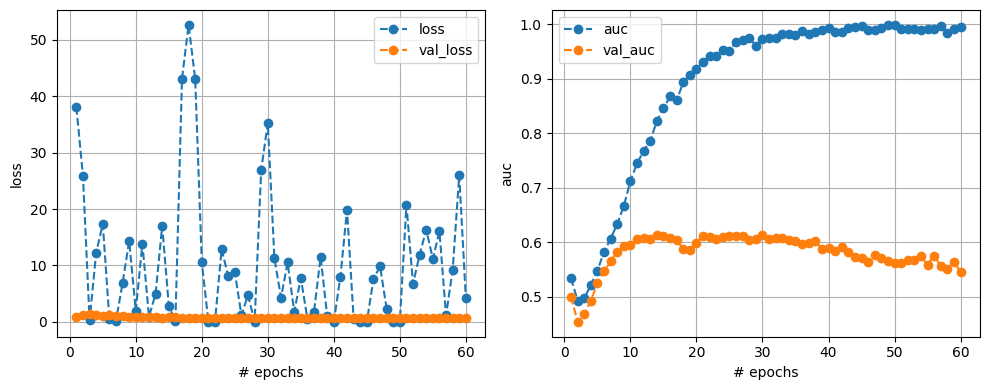

24/24 [==============================] - 6s 202ms/step - loss: 4.2669 - auc: 0.9937 - val_loss: 0.7355 - val_auc: 0.5453
Training time: 400.1781277656555 seconds


In [17]:
# Entrenamiento de la red
start = time.time()

pla_vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
pla_vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
pla_vgg_tl_plot_callback = PlotLearning()

history_fine_tuning = model_VGG16.fit(pla_prep_train_data,
                                      epochs=150,
                                      validation_data=pla_prep_val_data,
                                      callbacks=[pla_vgg_tl_callback,pla_vgg_tl_checkpoint,pla_vgg_tl_plot_callback],
                                      class_weight=pla_class_weights_dict
                                     )  

end = time.time()

print('Training time:', end - start, 'seconds')


Best threshold: 0.00 with F1-score: 0.25


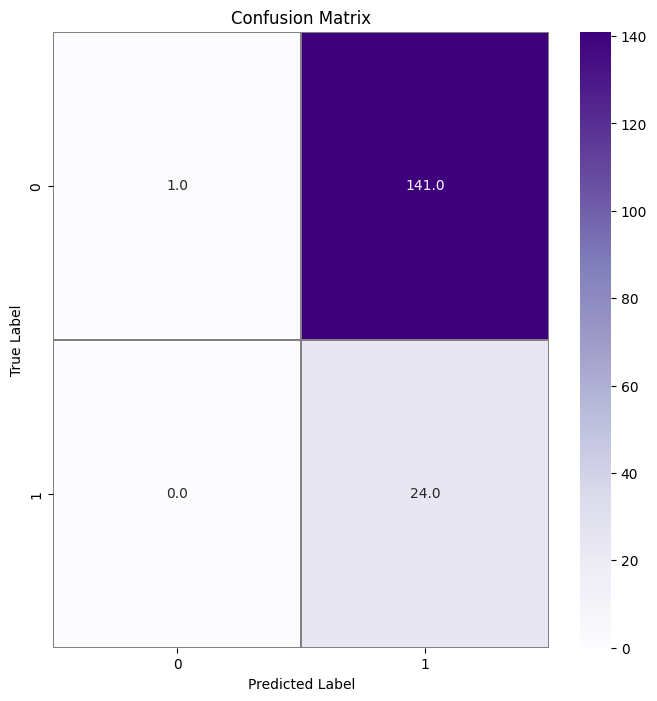

              precision    recall  f1-score   support

           0       1.00      0.01      0.01       142
           1       0.15      1.00      0.25        24

    accuracy                           0.15       166
   macro avg       0.57      0.50      0.13       166
weighted avg       0.88      0.15      0.05       166

  Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0   VGG16-TL  0.45                     0.25      0.15          1.0   

   Specificity   PPV  NPV   PLR  NLR  
0         0.01  0.15  1.0  1.01  0.0  


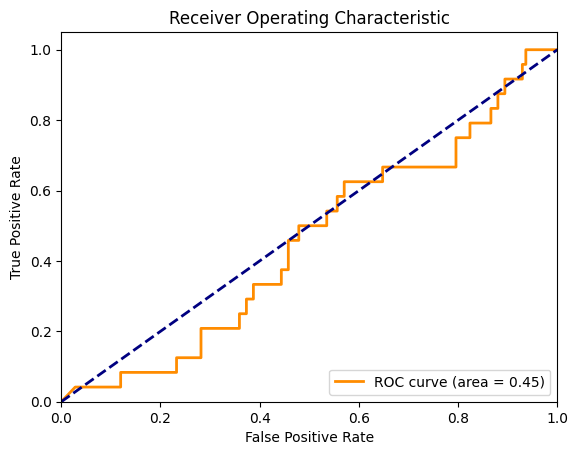

In [18]:
get_model_metrics(test_data=pla_prep_test_data, model=model_VGG16, model_name='VGG16-TL')

## 4.3. Train Placenta Classifier with IMG AUG (fine-tuning from previous model)

In [19]:
def augment_image(image, label):
    # Randomly apply different augmentations to the image
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.2)  # Adjust brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Adjust contrast
    return image, label

In [20]:
train_data_augmented = pla_prep_train_data.map(augment_image)

In [21]:
# create model again
model_VGG16 = build_model(base_model_VGG16, transfer_learning='Y')
model_VGG16.load_weights('/input/vgg-tl-best-weights-4-layers/vgg_tl_best_weights_4_layers.h5')

# Unfreeze four top layers
for layer in model_VGG16.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_VGG16.layers:
    print(layer, layer.trainable)
    
model_VGG16.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)

base_model.trainable set to False
<keras.src.engine.input_layer.InputLayer object at 0x7b1b3c792b60> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b1b3c792020> True
<keras.src.engine.functional.Functional object at 0x7b1bbc2951e0> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7b1b3c793ca0> True
<keras.src.layers.core.dense.Dense object at 0x7b1b3c790a30> True
<keras.src.layers.core.dense.Dense object at 0x7b1b3c5d33a0> True
<keras.src.layers.core.dense.Dense object at 0x7b1b3c5d2c20> True


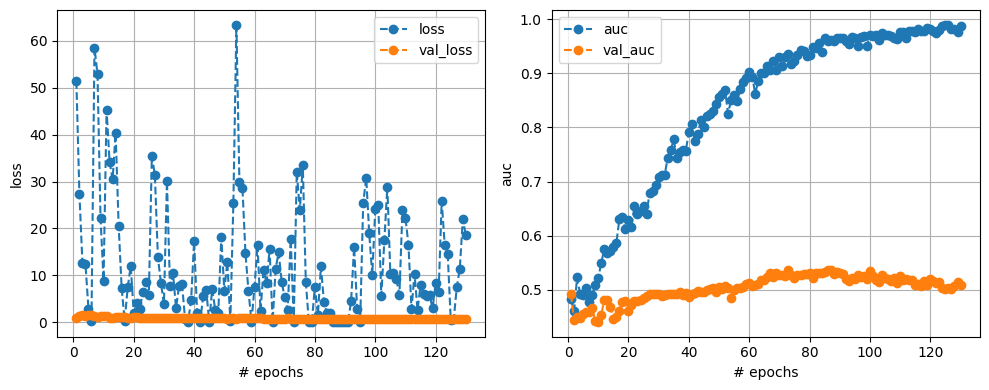

24/24 [==============================] - 6s 213ms/step - loss: 18.5741 - auc: 0.9871 - val_loss: 0.7564 - val_auc: 0.5097
Training time: 885.51247215271 seconds


In [22]:
# Entrenamiento de la red
start = time.time()

pla_vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
pla_vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
pla_vgg_tl_plot_callback = PlotLearning()

history_fine_tuning = model_VGG16.fit(train_data_augmented,
                                      epochs=150,
                                      steps_per_epoch=len(pla_train_data),
                                      validation_data=pla_prep_val_data,
                                      callbacks=[pla_vgg_tl_callback,pla_vgg_tl_checkpoint,pla_vgg_tl_plot_callback],
                                      class_weight=pla_class_weights_dict
                                     )  

end = time.time()

print('Training time:', end - start, 'seconds')


Best threshold: 0.00 with F1-score: 0.25


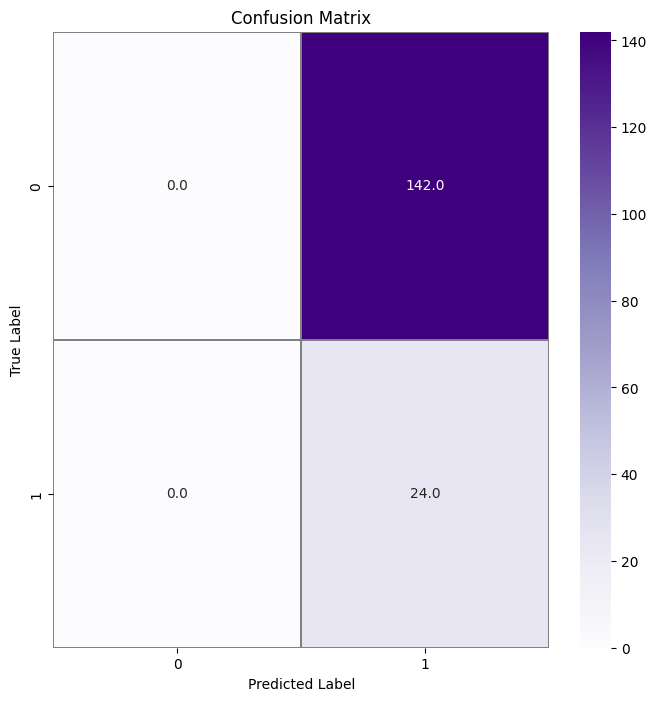

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_42/1616972866.py:58: RuntimeWarning: invalid valu

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       142
           1       0.14      1.00      0.25        24

    accuracy                           0.14       166
   macro avg       0.07      0.50      0.13       166
weighted avg       0.02      0.14      0.04       166

     Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  VGG16-TL-AUG  0.41                     0.25      0.14          1.0   

   Specificity   PPV  NPV  PLR  NLR  
0          0.0  0.14  NaN  1.0  NaN  


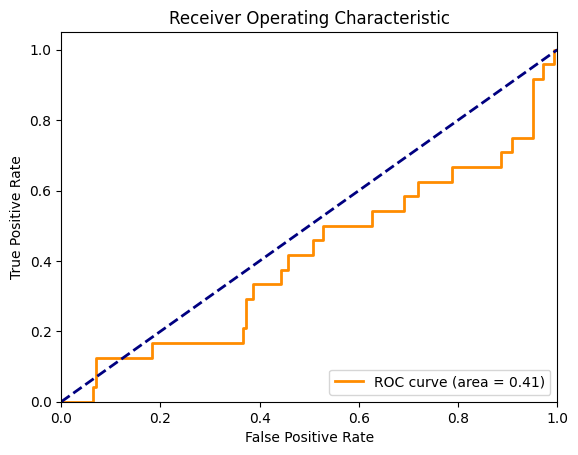

In [23]:
get_model_metrics(test_data=pla_prep_test_data, model=model_VGG16, model_name='VGG16-TL-AUG')

## 4.4. Train Placenta Classifier with IMG AUG and NO Class Weights (fine-tuning from previous model)

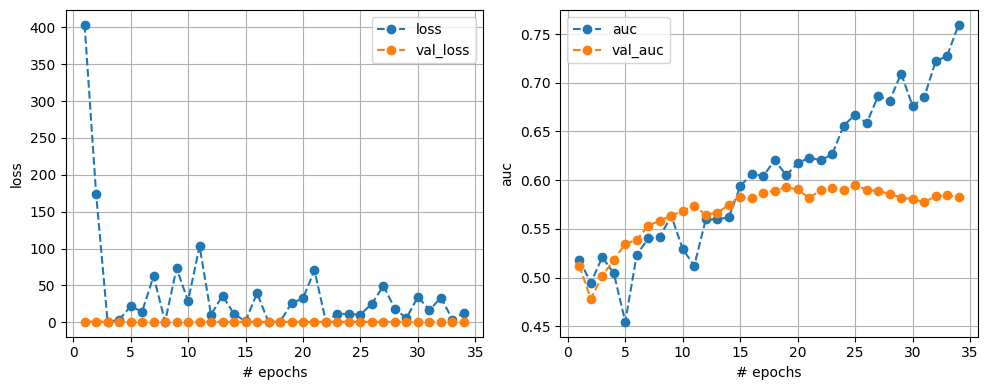

24/24 [==============================] - 6s 204ms/step - loss: 12.8919 - auc: 0.7594 - val_loss: 0.5936 - val_auc: 0.5825
Training time: 241.2966423034668 seconds


In [24]:
# create model again
model_VGG16 = build_model(base_model_VGG16, transfer_learning='Y')
model_VGG16.load_weights('/input/vgg-tl-best-weights-4-layers/vgg_tl_best_weights_4_layers.h5')

# Unfreeze four top layers 
for layer in model_VGG16.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_VGG16.layers:
    print(layer, layer.trainable)
    
model_VGG16.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)


# Entrenamiento de la red
start = time.time()

pla_vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
pla_vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
pla_vgg_tl_plot_callback = PlotLearning()

history_fine_tuning = model_VGG16.fit(train_data_augmented,
                                      epochs=150,
                                      steps_per_epoch=len(pla_train_data),
                                      validation_data=pla_prep_val_data,
                                      callbacks=[pla_vgg_tl_callback,pla_vgg_tl_checkpoint,pla_vgg_tl_plot_callback],
                                      #class_weight=pla_class_weights_dict
                                     )  

end = time.time()

print('Training time:', end - start, 'seconds')


Best threshold: 0.00 with F1-score: 0.25


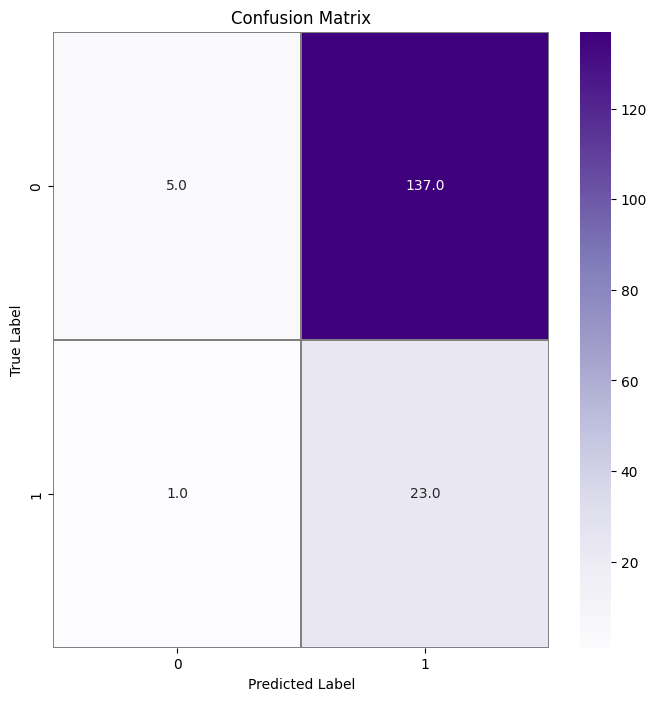

              precision    recall  f1-score   support

           0       0.83      0.04      0.07       142
           1       0.14      0.96      0.25        24

    accuracy                           0.17       166
   macro avg       0.49      0.50      0.16       166
weighted avg       0.73      0.17      0.09       166

           Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  VGG16-TL-AUG-no-CW  0.45                     0.25      0.17         0.96   

   Specificity   PPV   NPV   PLR   NLR  
0         0.04  0.14  0.83  0.99  1.18  


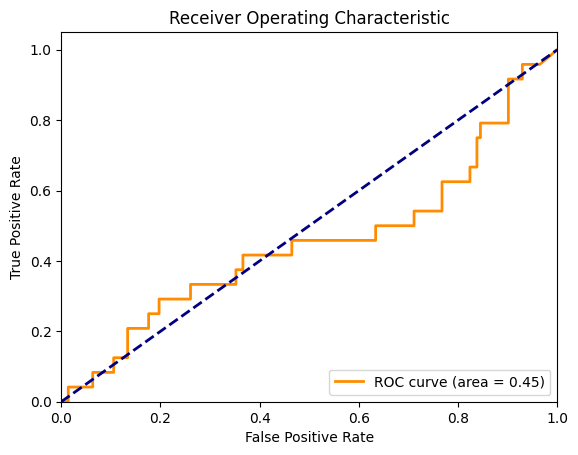

In [25]:
get_model_metrics(test_data=pla_prep_test_data, model=model_VGG16, model_name='VGG16-TL-AUG-no-CW')

# 4B. VGG16 NO Transfer Learning

1. Train a binary classifier on ultrasound images to classify brain vs not brain, based on VGG16 architecture. Four additional custom layers are added and no layers are frozen. The weights will be saved.

2. Create the same model architechture in order to train the placental ultrasound images. The weights from the previous model will be loaded, so the model has base layers with weights from the brain classifier, and then 4 layers to fine tune the placenta images.

## 4B.2. Train Placenta Classifier (fine-tuning from previous model)

In [26]:
## Placenta classifier
base_model_VGG16 = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Load saved brain model
model_VGG16 = build_model(base_model_VGG16, transfer_learning='Y')
model_VGG16.load_weights('/input/vgg-notl-best-weights-4-layers/vgg_notl_best_weights.h5')

base_model.trainable set to False


In [27]:
# Unfreeze four top layers
for layer in model_VGG16.layers[-4:]:  
    layer.trainable = True

# check the trainable status of the individual layers
for layer in model_VGG16.layers:
    print(layer, layer.trainable)

model_VGG16.compile(optimizer=Adam(learning_rate=1e-5),  # lower learning rate
                    loss='binary_crossentropy',
                    metrics=METRICS)

<keras.src.engine.input_layer.InputLayer object at 0x7b1b2468c970> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b1b69b85000> True
<keras.src.engine.functional.Functional object at 0x7b1b69b86c20> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7b1b3c2035b0> True
<keras.src.layers.core.dense.Dense object at 0x7b1b69b87e80> True
<keras.src.layers.core.dense.Dense object at 0x7b1b69b84430> True
<keras.src.layers.core.dense.Dense object at 0x7b1b69b85120> True


In [28]:
# preprocesar input
def convert_to_rgb(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.grayscale_to_rgb(image)
    return grayscale_image, label

pla_train_data_rgb = pla_train_data.map(convert_to_rgb)
pla_val_data_rgb = pla_val_data.map(convert_to_rgb)
pla_test_data_rgb = pla_test_data.map(convert_to_rgb)

pla_prep_train_data = pla_train_data_rgb.map(lambda x, y: (preprocess_input(x), y))
pla_prep_val_data = pla_val_data_rgb.map(lambda x, y: (preprocess_input(x), y))
pla_prep_test_data = pla_test_data_rgb.map(lambda x, y: (preprocess_input(x), y))

def convert_to_grayscale(image, label):
    # Convert the image from RGB to grayscale
    grayscale_image = tf.image.rgb_to_grayscale(image)
    return grayscale_image, label

# Apply the conversion to your datasets
pla_prep_train_data = pla_prep_train_data.map(convert_to_grayscale)
pla_prep_val_data = pla_prep_val_data.map(convert_to_grayscale)
pla_prep_test_data = pla_prep_test_data.map(convert_to_grayscale)

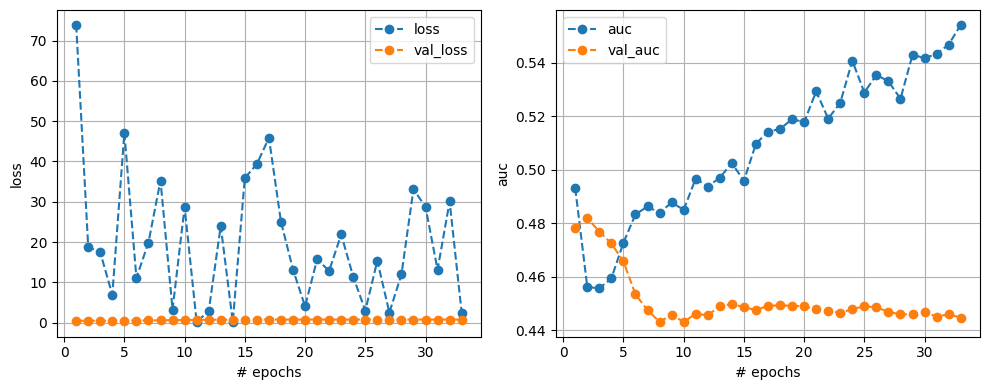

24/24 [==============================] - 6s 204ms/step - loss: 2.4656 - auc: 0.5541 - val_loss: 0.7557 - val_auc: 0.4448
Training time: 230.2578101158142 seconds


In [29]:
# Entrenamiento de la red
start = time.time()

pla_vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
pla_vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
pla_vgg_tl_plot_callback = PlotLearning()

history_fine_tuning = model_VGG16.fit(pla_prep_train_data,
                                      epochs=150,
                                      validation_data=pla_prep_val_data,
                                      callbacks=[pla_vgg_tl_callback,pla_vgg_tl_checkpoint,pla_vgg_tl_plot_callback],
                                      class_weight=pla_class_weights_dict
                                     )  

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.51 with F1-score: 0.31


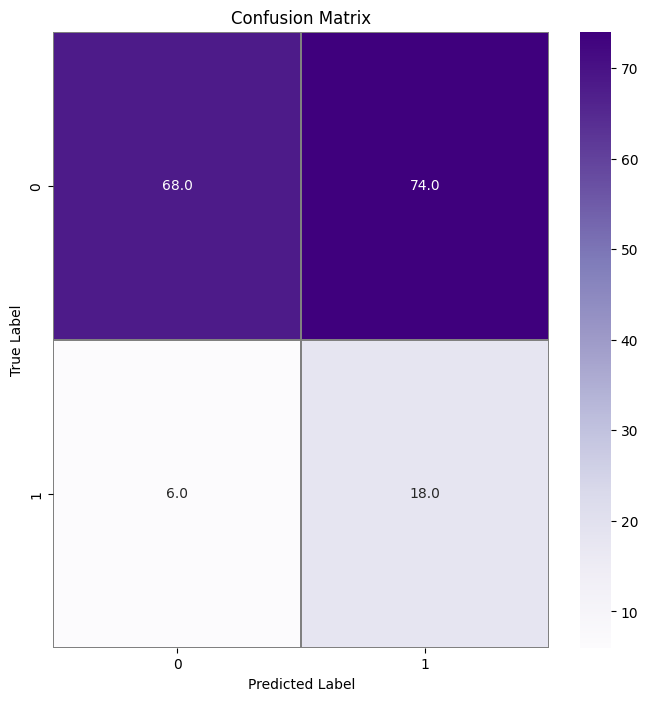

              precision    recall  f1-score   support

           0       0.92      0.48      0.63       142
           1       0.20      0.75      0.31        24

    accuracy                           0.52       166
   macro avg       0.56      0.61      0.47       166
weighted avg       0.81      0.52      0.58       166

    Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  VGG16-no-TL  0.56                     0.31      0.52         0.75   

   Specificity  PPV   NPV   PLR   NLR  
0         0.48  0.2  0.92  1.44  0.52  


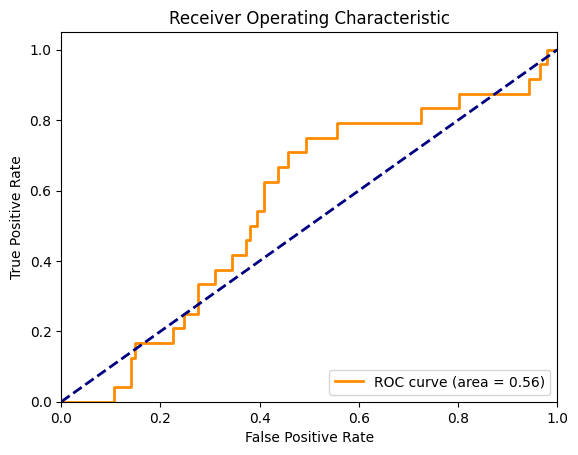

In [30]:
get_model_metrics(test_data=pla_prep_test_data, model=model_VGG16, model_name='VGG16-no-TL')

## 4B.3. Train Placenta Classifier with IMG AUG

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator with augmentations for the training set
train_datagen = ImageDataGenerator(
    rotation_range=20,       # random rotation
    width_shift_range=0.2,   # random horizontal shift
    height_shift_range=0.2,  # random vertical shift
    shear_range=0.2,         # shear transformation
    zoom_range=0.2,          # random zoom
    horizontal_flip=True,    # random horizontal flip
    fill_mode='nearest'      # fill strategy
)

# Convert tf.data.Dataset to a format compatible with ImageDataGenerator
def get_generator(dataset, datagen):
    for images, labels in dataset:
        yield from datagen.flow(images.numpy(), labels.numpy(), batch_size=32)

In [32]:
train_data_augmented = pla_prep_train_data.map(augment_image)

In [33]:
# create model again
model_VGG16 = build_model(base_model_VGG16, transfer_learning='Y')
model_VGG16.load_weights('/input/vgg-notl-best-weights-4-layers/vgg_notl_best_weights.h5')

# Unfreeze four top layers
for layer in model_VGG16.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_VGG16.layers:
    print(layer, layer.trainable)
    
model_VGG16.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)

base_model.trainable set to False
<keras.src.engine.input_layer.InputLayer object at 0x7b1bbc124ac0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b1b3c793ee0> True
<keras.src.engine.functional.Functional object at 0x7b1b69b86c20> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7b1bbc125780> True
<keras.src.layers.core.dense.Dense object at 0x7b1bbc296fe0> True
<keras.src.layers.core.dense.Dense object at 0x7b1bbc1601f0> True
<keras.src.layers.core.dense.Dense object at 0x7b1b4c217880> True


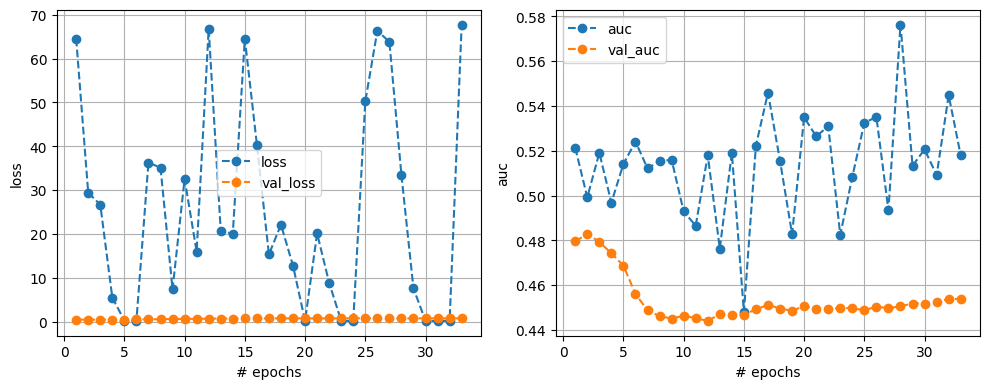

24/24 [==============================] - 6s 203ms/step - loss: 67.7799 - auc: 0.5179 - val_loss: 0.7349 - val_auc: 0.4540
Training time: 234.25653910636902 seconds


In [34]:
# Entrenamiento de la red
start = time.time()

pla_vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30)
pla_vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
pla_vgg_tl_plot_callback = PlotLearning()

history_fine_tuning = model_VGG16.fit(train_data_augmented,
                                      epochs=150,
                                      steps_per_epoch=len(pla_train_data),
                                      validation_data=pla_prep_val_data,
                                      callbacks=[pla_vgg_tl_callback,pla_vgg_tl_checkpoint,pla_vgg_tl_plot_callback],
                                      class_weight=pla_class_weights_dict
                                     )  

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.53 with F1-score: 0.32


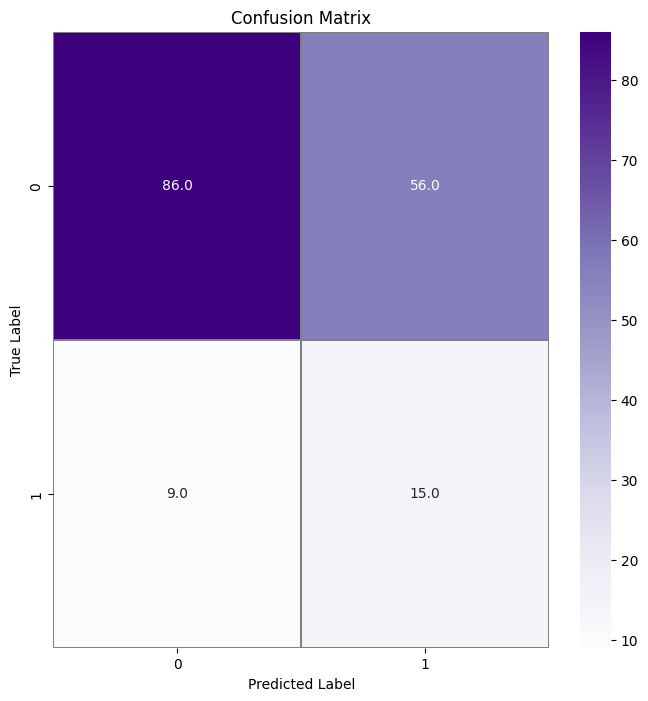

              precision    recall  f1-score   support

           0       0.91      0.61      0.73       142
           1       0.21      0.62      0.32        24

    accuracy                           0.61       166
   macro avg       0.56      0.62      0.52       166
weighted avg       0.80      0.61      0.67       166

        Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  VGG16-no-TL-AUG  0.53                     0.32      0.61         0.62   

   Specificity   PPV   NPV   PLR   NLR  
0         0.61  0.21  0.91  1.58  0.62  


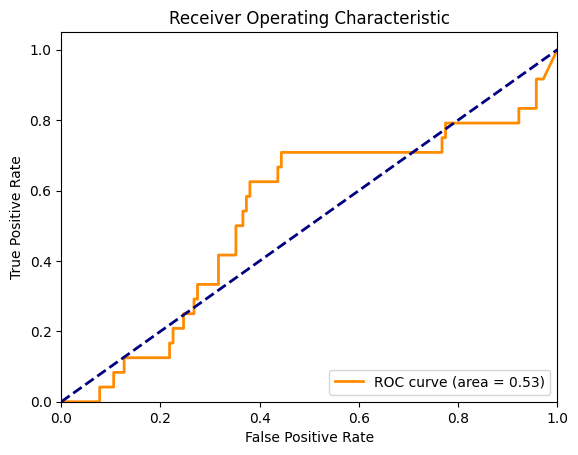

In [35]:
get_model_metrics(test_data=pla_prep_test_data, model=model_VGG16, model_name='VGG16-no-TL-AUG')

## 4B.4. Train Placenta Classifier with IMG AUG and NO Class Weights (fine-tuning from previous model)

In [36]:
# create model again
model_VGG16 = build_model(base_model_VGG16, transfer_learning='Y')
model_VGG16.load_weights('/input/vgg-notl-best-weights-4-layers/vgg_notl_best_weights.h5')

# Unfreeze four top layers 
for layer in model_VGG16.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_VGG16.layers:
    print(layer, layer.trainable)
    
model_VGG16.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)

base_model.trainable set to False
<keras.src.engine.input_layer.InputLayer object at 0x7b1b243a5c60> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b1b3c3755d0> True
<keras.src.engine.functional.Functional object at 0x7b1b69b86c20> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7b1b243a7a60> True
<keras.src.layers.core.dense.Dense object at 0x7b1b3c374fa0> True
<keras.src.layers.core.dense.Dense object at 0x7b1b4c0cfd00> True
<keras.src.layers.core.dense.Dense object at 0x7b1b4c0cfbe0> True


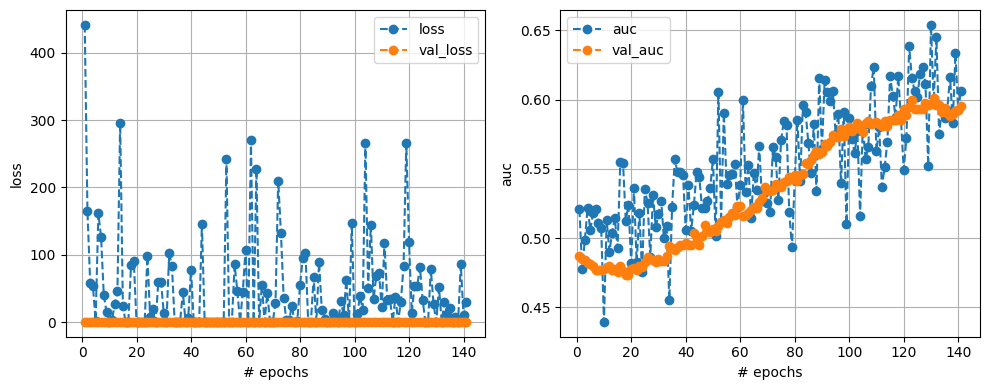

24/24 [==============================] - 6s 204ms/step - loss: 29.6989 - auc: 0.6063 - val_loss: 0.3987 - val_auc: 0.5952
Training time: 1002.1730754375458 seconds


In [37]:
# Entrenamiento de la red
start = time.time()

pla_vgg_tl_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
pla_vgg_tl_checkpoint = ModelCheckpoint('vgg_tl_best_weights.h5', save_best_only=True, save_weights_only=True)
pla_vgg_tl_plot_callback = PlotLearning()

history_fine_tuning = model_VGG16.fit(train_data_augmented,
                                      epochs=150,
                                      steps_per_epoch=len(pla_train_data),
                                      validation_data=pla_prep_val_data,
                                      callbacks=[pla_vgg_tl_callback,pla_vgg_tl_checkpoint,pla_vgg_tl_plot_callback],
                                      #class_weight=pla_class_weights_dict
                                     )  

end = time.time()

print('Training time:', end - start, 'seconds')

Best threshold: 0.00 with F1-score: 0.25


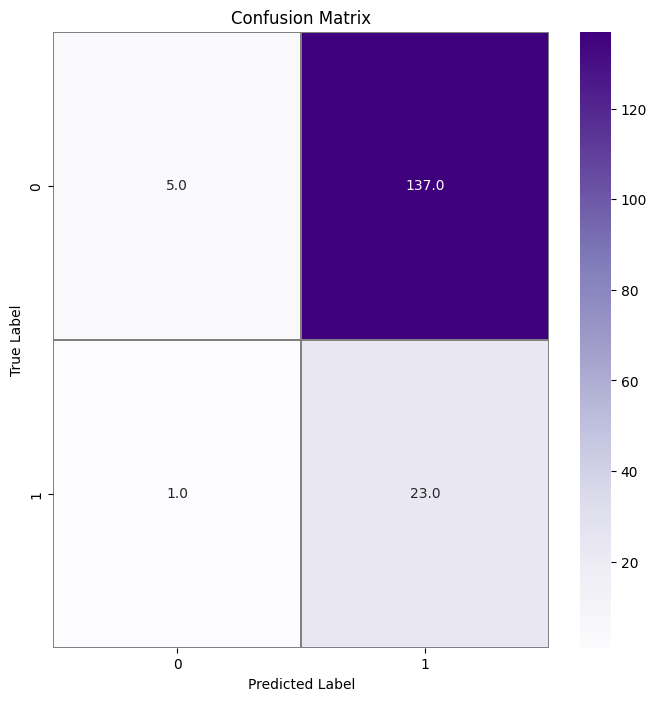

              precision    recall  f1-score   support

           0       0.83      0.04      0.07       142
           1       0.14      0.96      0.25        24

    accuracy                           0.17       166
   macro avg       0.49      0.50      0.16       166
weighted avg       0.73      0.17      0.09       166

              Model Name   AUC  F1-Score Positive Class  Accuracy  \
0  VGG16-no-TL-AUG-no-CW  0.48                     0.25      0.17   

   Sensitivity  Specificity   PPV   NPV   PLR   NLR  
0         0.96         0.04  0.14  0.83  0.99  1.18  


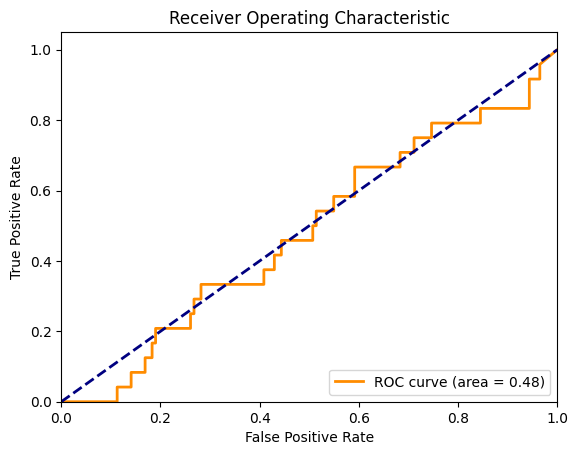

In [38]:
get_model_metrics(test_data=pla_prep_test_data, model=model_VGG16, model_name='VGG16-no-TL-AUG-no-CW')

# 5. ResNet18 TL

1. Train a binary classifier on ultrasound images to classify brain vs not brain, based on ResNet18 architecture. All layers are frozen except for the last 4 layers (new weights will be calculated based on the ultrasound images), and 4 additional custom layers are added. The weights will be saved.

2. Create the same model architechture in order to train the placental ultrasound images. The weights from the previous model will be loaded, so the model has base layers with weights from Imagenet, then 4 layers with weights fine tuned by the brain classifier, and then 4 layers to fine tune the placenta images.

In [39]:
!pip install image-classifiers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.5 MB/s eta 0:00:00


In [40]:
from classification_models.tfkeras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')

## 5.1. Train Brains Classifier

## 5.2. Train Placenta Classifier (fine-tuning from previous model)

In [41]:
def preprocess_data_resnet18(image, label):
    image = preprocess_input(image)
    return image, label

pla_prep_train_data = pla_train_data.map(preprocess_data_resnet18)
pla_prep_val_data = pla_val_data.map(preprocess_data_resnet18)
pla_prep_test_data = pla_test_data.map(preprocess_data_resnet18)

In [42]:
# create model again
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')
model_resnet18.load_weights('/input/rn18-best-weights-4-layers/rn18_best_weights_4_layers.h5', by_name=True)

# Unfreeze four top layers of the model
for layer in model_resnet18.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_resnet18.layers:
    print(layer, layer.trainable)
    
model_resnet18.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)

44920640/44920640 [==============================] - 0s 0us/step
base_model.trainable set to False
<keras.src.engine.input_layer.InputLayer object at 0x7b1b3c2f1690> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b1b3c1abb80> True
<keras.src.engine.functional.Functional object at 0x7b1b3c2f36d0> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7b171c5cc700> True
<keras.src.layers.core.dense.Dense object at 0x7b1b3c1a8670> True
<keras.src.layers.core.dense.Dense object at 0x7b1b4c557a30> True
<keras.src.layers.core.dense.Dense object at 0x7b1b2475ad70> True


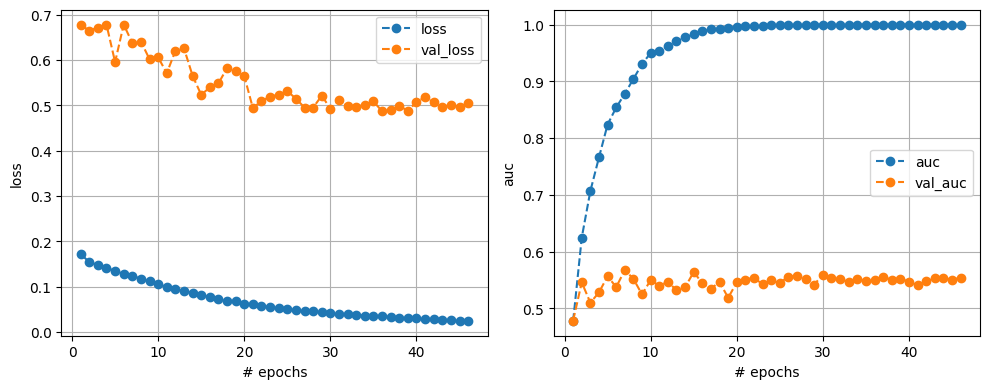

24/24 [==============================] - 4s 124ms/step - loss: 0.0245 - auc: 1.0000 - val_loss: 0.5055 - val_auc: 0.5543


In [43]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(pla_prep_train_data,
                    epochs=150,
                    validation_data=pla_prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    class_weight=pla_class_weights_dict
                    )

Best threshold: 0.00 with F1-score: 0.25


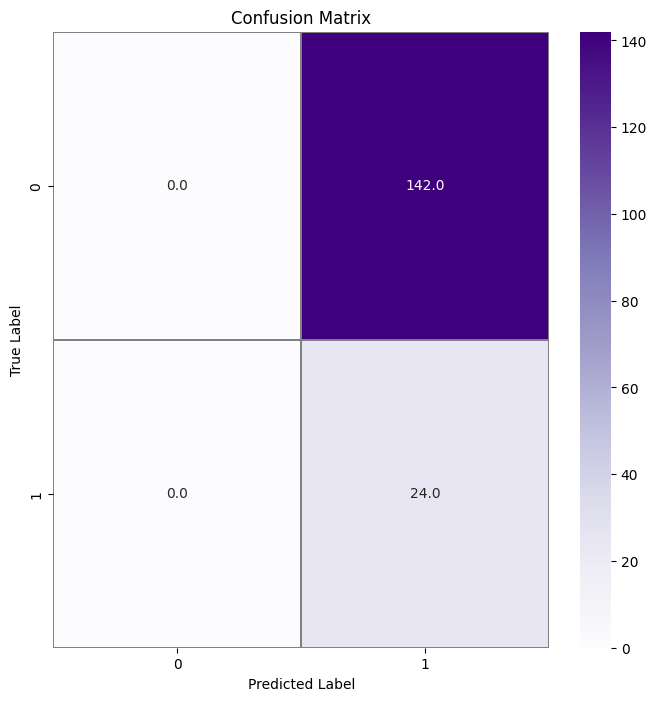

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/tmp/ipykernel_42/1616972866.py:58: RuntimeWarning: invalid valu

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       142
           1       0.14      1.00      0.25        24

    accuracy                           0.14       166
   macro avg       0.07      0.50      0.13       166
weighted avg       0.02      0.14      0.04       166

    Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet18-TL  0.47                     0.25      0.14          1.0   

   Specificity   PPV  NPV  PLR  NLR  
0          0.0  0.14  NaN  1.0  NaN  


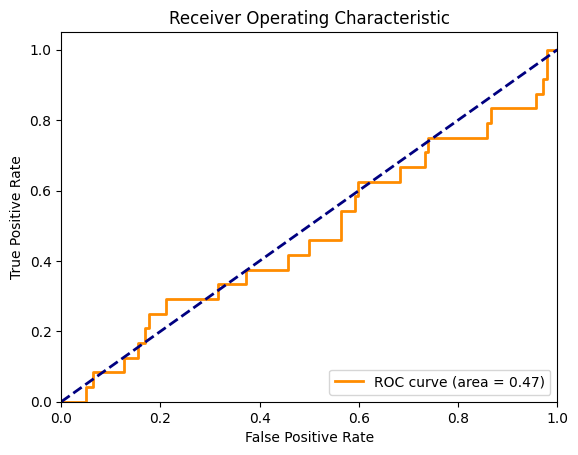

In [44]:
get_model_metrics(test_data=pla_prep_test_data, model=model_resnet18, model_name='ResNet18-TL')

## 5.3. Train Placenta Classifier with IMG AUG (fine-tuning from previous model)

In [45]:
train_data_augmented = pla_prep_train_data.map(augment_image)

In [46]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')
model_resnet18.load_weights('/input/rn18-best-weights-4-layers/rn18_best_weights_4_layers.h5', by_name=True)

# Unfreeze four top layers
for layer in model_resnet18.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_resnet18.layers:
    print(layer, layer.trainable)
    
model_resnet18.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)


base_model.trainable set to False
<keras.src.engine.input_layer.InputLayer object at 0x7b1b3ca1cbb0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b1b4c2c21d0> True
<keras.src.engine.functional.Functional object at 0x7b171c5cc340> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7b1b4c0ffd90> True
<keras.src.layers.core.dense.Dense object at 0x7b1bbc28dae0> True
<keras.src.layers.core.dense.Dense object at 0x7b1b3c794b20> True
<keras.src.layers.core.dense.Dense object at 0x7b1b3c795450> True


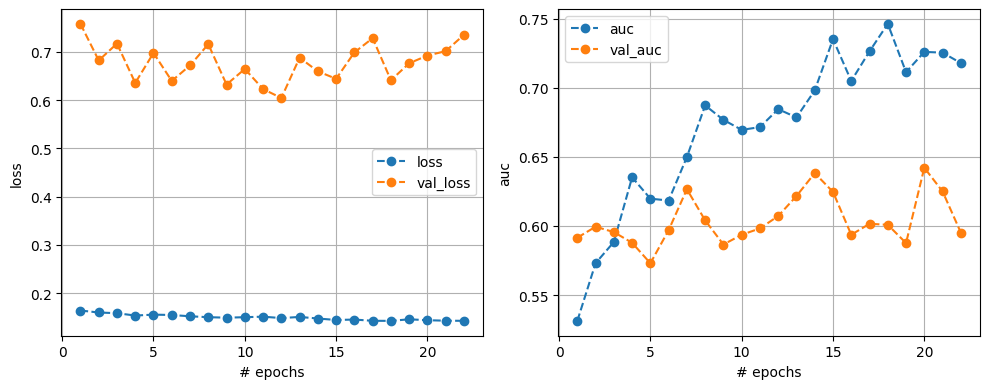

24/24 [==============================] - 4s 132ms/step - loss: 0.1424 - auc: 0.7179 - val_loss: 0.7353 - val_auc: 0.5952


In [47]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(pla_train_data),
                    validation_data=pla_prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    class_weight=pla_class_weights_dict
                    )

Best threshold: 0.30 with F1-score: 0.27


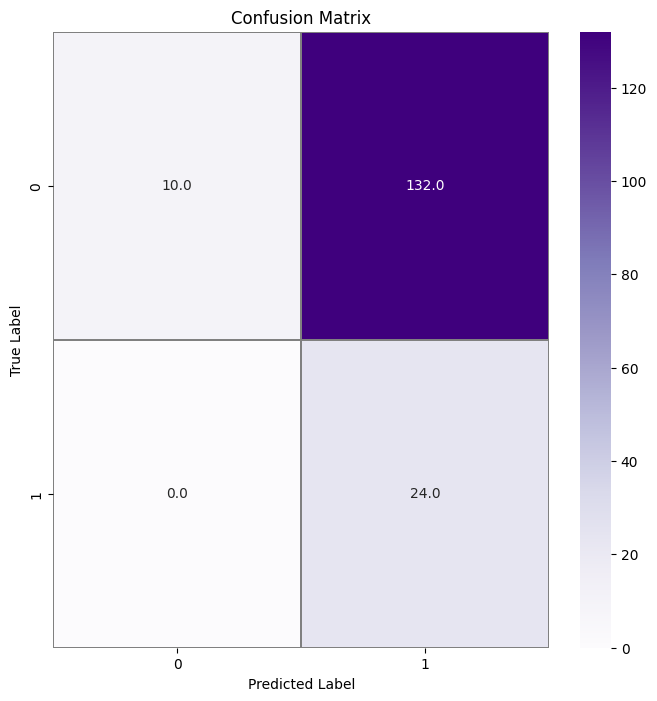

              precision    recall  f1-score   support

           0       1.00      0.07      0.13       142
           1       0.15      1.00      0.27        24

    accuracy                           0.20       166
   macro avg       0.58      0.54      0.20       166
weighted avg       0.88      0.20      0.15       166

        Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet18-TL-AUG  0.49                     0.27       0.2          1.0   

   Specificity   PPV  NPV   PLR  NLR  
0         0.07  0.15  1.0  1.08  0.0  


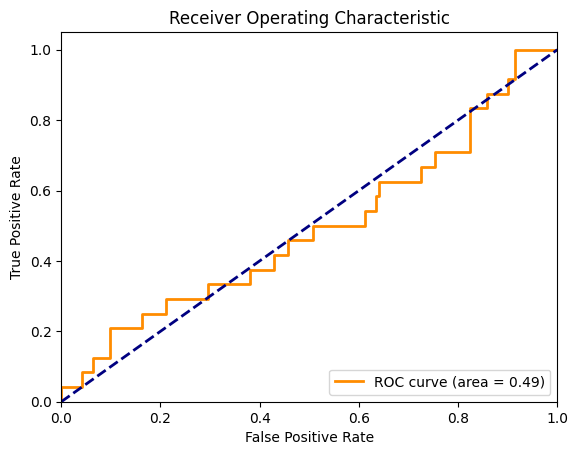

In [48]:
get_model_metrics(test_data=pla_prep_test_data, model=model_resnet18, model_name='ResNet18-TL-AUG')

## 5.4. Train Placenta Classifier with IMG AUG and NO Class Weights (fine-tuning from previous model)

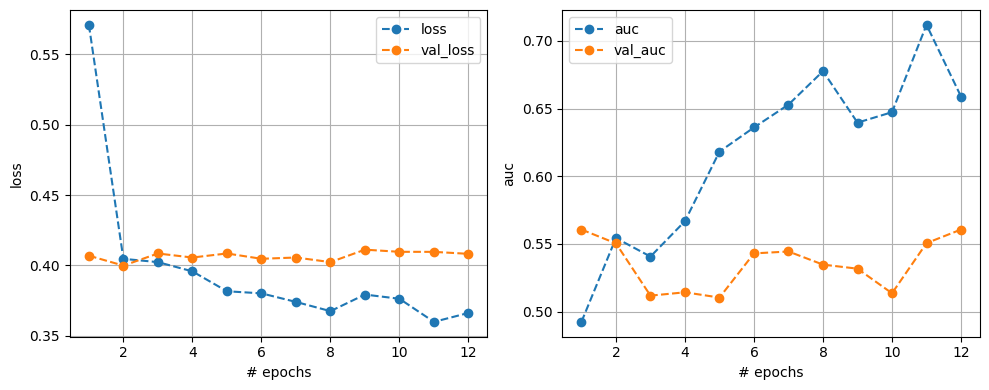

24/24 [==============================] - 4s 132ms/step - loss: 0.3663 - auc: 0.6589 - val_loss: 0.4083 - val_auc: 0.5607


In [49]:
# without class weights
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')
model_resnet18.load_weights('/input/rn18-best-weights-4-layers/rn18_best_weights_4_layers.h5', by_name=True)

# Unfreeze four top layers
for layer in model_resnet18.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_resnet18.layers:
    print(layer, layer.trainable)
    
model_resnet18.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)

rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(pla_train_data),
                    validation_data=pla_prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    #class_weight=class_weights_dict
                    )


Best threshold: 0.05 with F1-score: 0.26


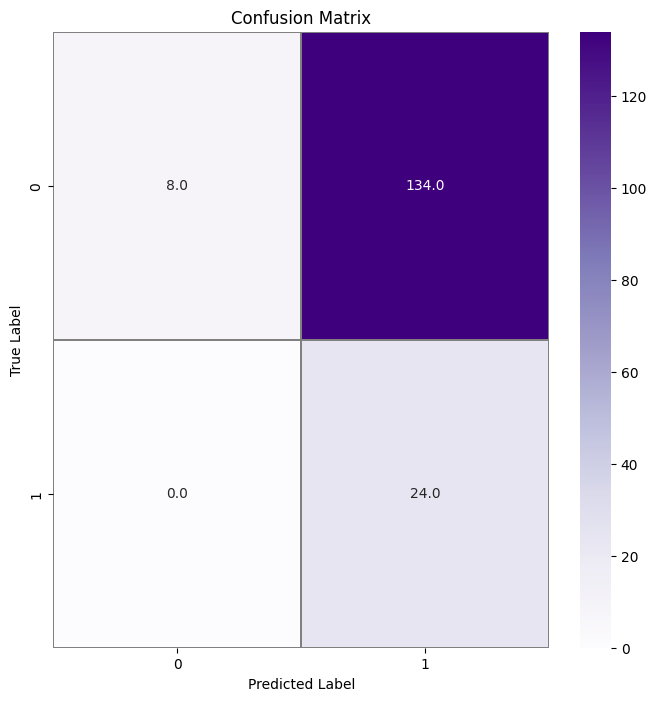

              precision    recall  f1-score   support

           0       1.00      0.06      0.11       142
           1       0.15      1.00      0.26        24

    accuracy                           0.19       166
   macro avg       0.58      0.53      0.19       166
weighted avg       0.88      0.19      0.13       166

              Model Name   AUC  F1-Score Positive Class  Accuracy  \
0  ResNet18-TL-AUG-no-CW  0.51                     0.26      0.19   

   Sensitivity  Specificity   PPV  NPV   PLR  NLR  
0          1.0         0.06  0.15  1.0  1.06  0.0  


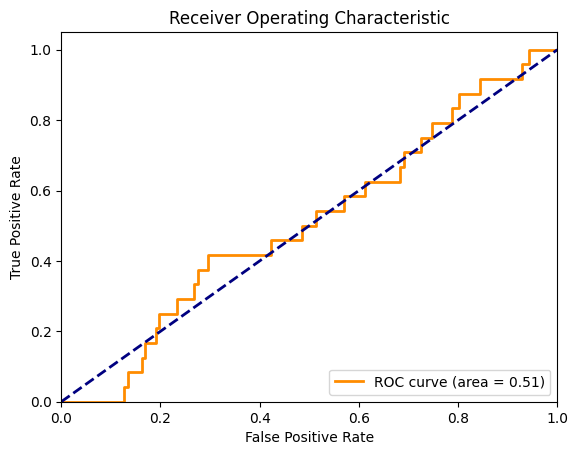

In [50]:
get_model_metrics(test_data=pla_prep_test_data, model=model_resnet18, model_name='ResNet18-TL-AUG-no-CW')

# 5B. ResNet18 NO TL

1. Train a binary classifier on ultrasound images to classify brain vs not brain, based on ResNet18 architecture. Four additional custom layers are added and no layers are frozen. The weights will be saved.

2. Create the same model architechture in order to train the placental ultrasound images. The weights from the previous model will be loaded, so the model has base layers with weights from the brain classifier, and then 4 layers to fine tune the placenta images.

In [51]:
!pip install image-classifiers

In [52]:
from classification_models.tfkeras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')

## 5B.1. Train Brains Classifier

## 5B.2. Train Placenta Classifier

In [53]:
def preprocess_data_resnet18(image, label):
    image = preprocess_input(image)
    return image, label

pla_prep_train_data = pla_train_data.map(preprocess_data_resnet18)
pla_prep_val_data = pla_val_data.map(preprocess_data_resnet18)
pla_prep_test_data = pla_test_data.map(preprocess_data_resnet18)

In [54]:
# create model again
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')
model_resnet18.load_weights('/input/rn18-notl-best-weights/rn18_noTL_best_weights.h5', by_name=True)

# Unfreeze four top layers of the model
for layer in model_resnet18.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_resnet18.layers:
    print(layer, layer.trainable)
    
model_resnet18.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)

base_model.trainable set to False
<keras.src.engine.input_layer.InputLayer object at 0x7b1b246192d0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b1b24200c10> True
<keras.src.engine.functional.Functional object at 0x7b1b3c70c0d0> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7b1b24202140> True
<keras.src.layers.core.dense.Dense object at 0x7b1b242021d0> True
<keras.src.layers.core.dense.Dense object at 0x7b1b4c1f1330> True
<keras.src.layers.core.dense.Dense object at 0x7b1b4c1f31c0> True


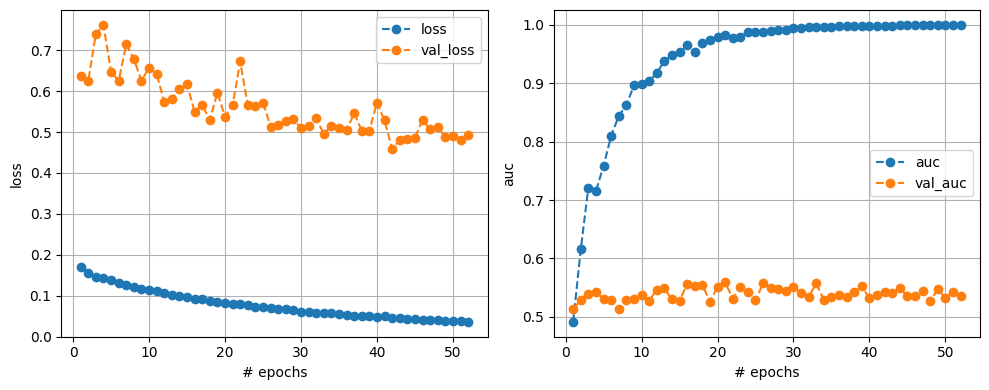

24/24 [==============================] - 4s 123ms/step - loss: 0.0361 - auc: 0.9996 - val_loss: 0.4930 - val_auc: 0.5358


In [55]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(pla_prep_train_data,
                    epochs=150,
                    validation_data=pla_prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    class_weight=pla_class_weights_dict
                    )

Best threshold: 0.22 with F1-score: 0.33


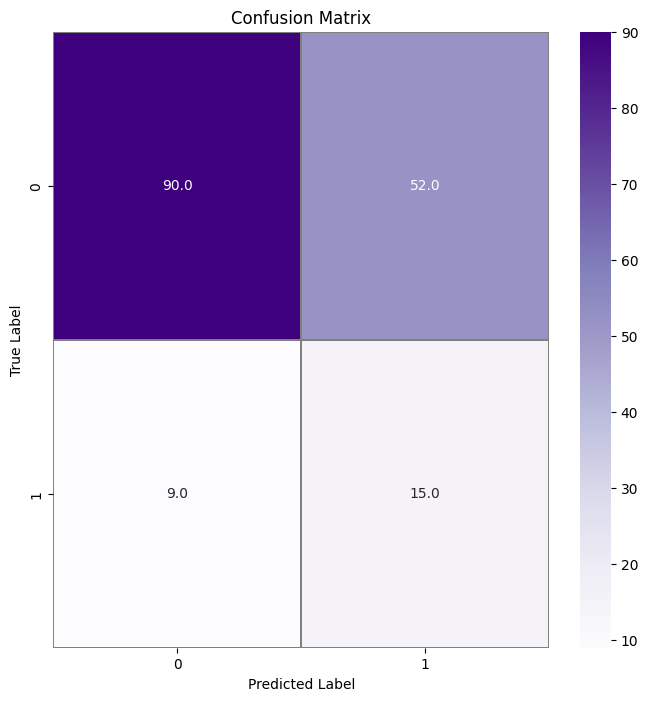

              precision    recall  f1-score   support

           0       0.91      0.63      0.75       142
           1       0.22      0.62      0.33        24

    accuracy                           0.63       166
   macro avg       0.57      0.63      0.54       166
weighted avg       0.81      0.63      0.69       166

       Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet18-no-TL  0.62                     0.33      0.63         0.62   

   Specificity   PPV   NPV   PLR   NLR  
0         0.63  0.22  0.91  1.71  0.59  


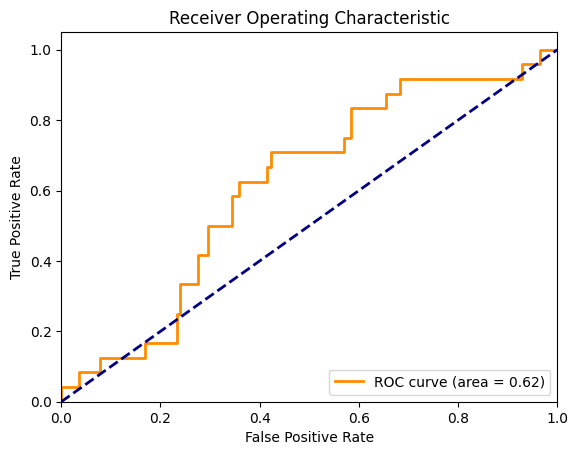

In [56]:
get_model_metrics(test_data=pla_prep_test_data, model=model_resnet18, model_name='ResNet18-no-TL')

## 5B.3. Train Placenta Classifier with IMG AUG

In [57]:
train_data_augmented = pla_prep_train_data.map(augment_image)

In [58]:
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')
model_resnet18.load_weights('/input/rn18-notl-best-weights/rn18_noTL_best_weights.h5', by_name=True)

base_model.trainable set to False


In [59]:
# Unfreeze four top layers
for layer in model_resnet18.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_resnet18.layers:
    print(layer, layer.trainable)
    
model_resnet18.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)

<keras.src.engine.input_layer.InputLayer object at 0x7b1b3c150cd0> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b1b3c48aaa0> True
<keras.src.engine.functional.Functional object at 0x7b1b3c489e40> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7b1b7bfd7f70> True
<keras.src.layers.core.dense.Dense object at 0x7b1b3c48a9e0> True
<keras.src.layers.core.dense.Dense object at 0x7b1b3c488ee0> True
<keras.src.layers.core.dense.Dense object at 0x7b1b3c489390> True


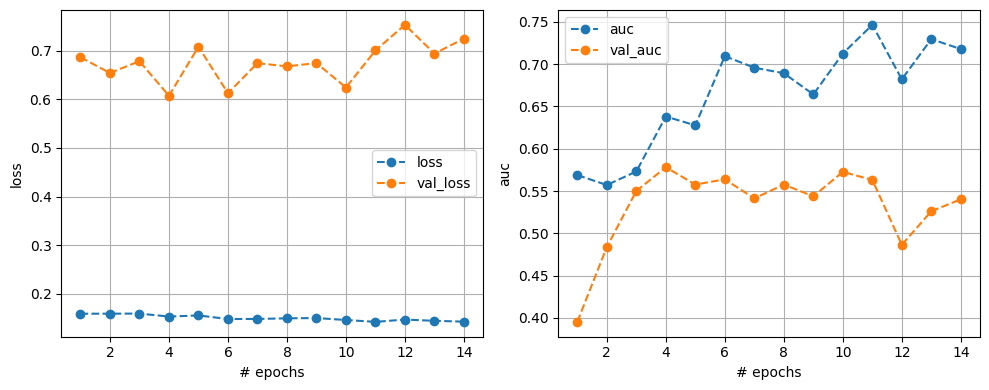

24/24 [==============================] - 4s 132ms/step - loss: 0.1429 - auc: 0.7179 - val_loss: 0.7248 - val_auc: 0.5402


In [60]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(pla_train_data),
                    validation_data=pla_prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    class_weight=pla_class_weights_dict
                    )

Best threshold: 0.13 with F1-score: 0.26


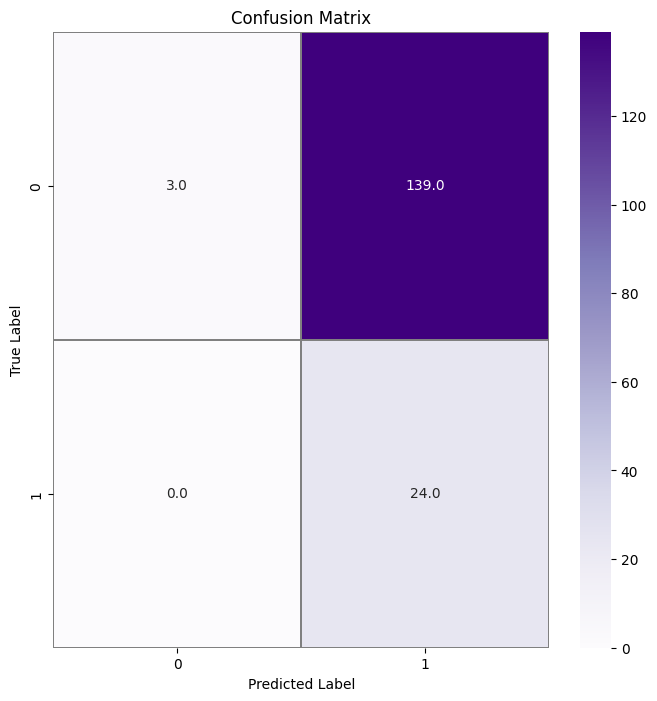

              precision    recall  f1-score   support

           0       1.00      0.02      0.04       142
           1       0.15      1.00      0.26        24

    accuracy                           0.16       166
   macro avg       0.57      0.51      0.15       166
weighted avg       0.88      0.16      0.07       166

           Model Name  AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet18-no-TL-AUG  0.4                     0.26      0.16          1.0   

   Specificity   PPV  NPV   PLR  NLR  
0         0.02  0.15  1.0  1.02  0.0  


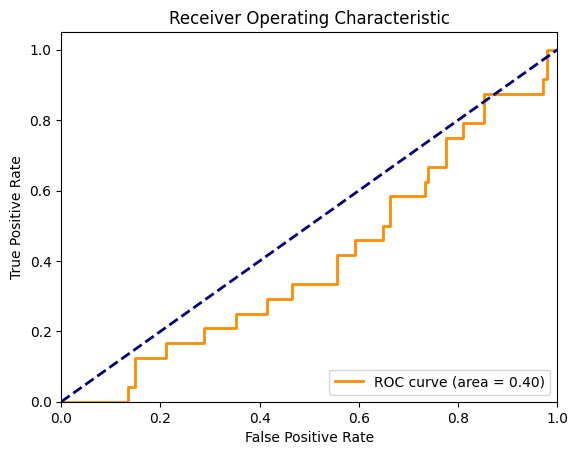

In [61]:
get_model_metrics(test_data=pla_prep_test_data, model=model_resnet18, model_name='ResNet18-no-TL-AUG')

## 5B.4. Train Placenta Classifier with IMG AUG and no class weights

In [62]:
# without class weights
base_resnet18 = ResNet18(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_resnet18 = build_model(base_model=base_resnet18, transfer_learning='Y')
model_resnet18.load_weights('/input/rn18-notl-best-weights/rn18_noTL_best_weights.h5', by_name=True)

# Unfreeze four top layers
for layer in model_resnet18.layers[-4:]:
    layer.trainable = True

# Check the trainable status of the individual layers
for layer in model_resnet18.layers:
    print(layer, layer.trainable)
    
model_resnet18.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate
                loss='binary_crossentropy',
                metrics=METRICS)

base_model.trainable set to False
<keras.src.engine.input_layer.InputLayer object at 0x7b1b4c4f0f10> True
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7b171ebd1c90> True
<keras.src.engine.functional.Functional object at 0x7b1b247383a0> False
<keras.src.layers.reshaping.flatten.Flatten object at 0x7b171c5ce8c0> True
<keras.src.layers.core.dense.Dense object at 0x7b1b24738940> True
<keras.src.layers.core.dense.Dense object at 0x7b1b24738640> True
<keras.src.layers.core.dense.Dense object at 0x7b1b2473a980> True


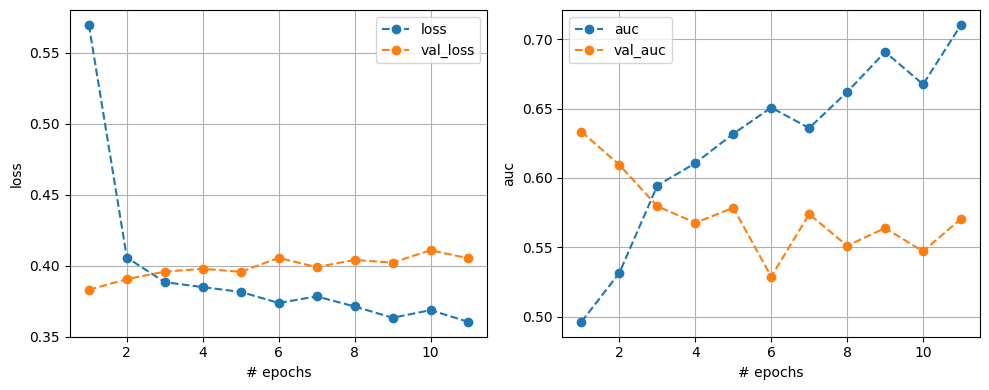

24/24 [==============================] - 4s 133ms/step - loss: 0.3603 - auc: 0.7103 - val_loss: 0.4051 - val_auc: 0.5705


In [63]:
rn18_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
rn18_checkpoint = ModelCheckpoint('rn18_best_weights.h5', save_best_only=True, save_weights_only=True)
rn18_plot_callback = PlotLearning()

history = model_resnet18.fit(train_data_augmented,
                    epochs=150,
                    steps_per_epoch=len(pla_train_data),
                    validation_data=pla_prep_val_data,
                    callbacks=[rn18_callback, rn18_checkpoint, rn18_plot_callback],
                    batch_size=32,
                    #class_weight=pla_class_weights_dict
                    )

Best threshold: 0.05 with F1-score: 0.26


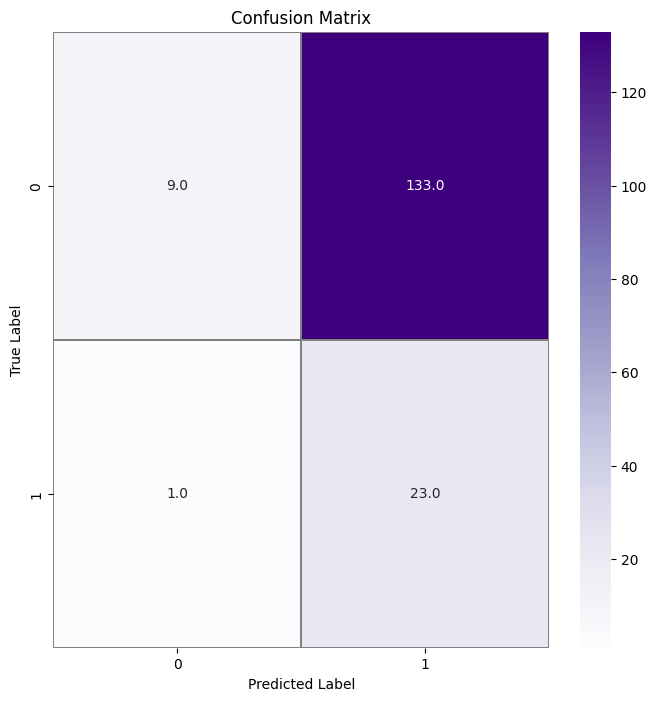

              precision    recall  f1-score   support

           0       0.90      0.06      0.12       142
           1       0.15      0.96      0.26        24

    accuracy                           0.19       166
   macro avg       0.52      0.51      0.19       166
weighted avg       0.79      0.19      0.14       166

             Model Name   AUC  F1-Score Positive Class  Accuracy  Sensitivity  \
0  ResNet18-no-TL-no-CW  0.38                     0.26      0.19         0.96   

   Specificity   PPV  NPV   PLR   NLR  
0         0.06  0.15  0.9  1.02  0.66  


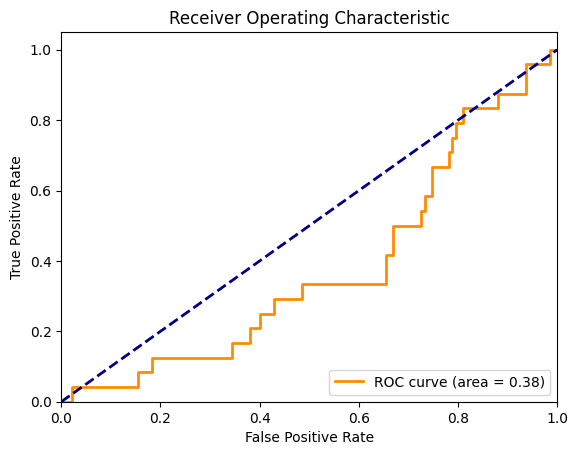

In [64]:
get_model_metrics(test_data=pla_prep_test_data, model=model_resnet18, model_name='ResNet18-no-TL-no-CW')